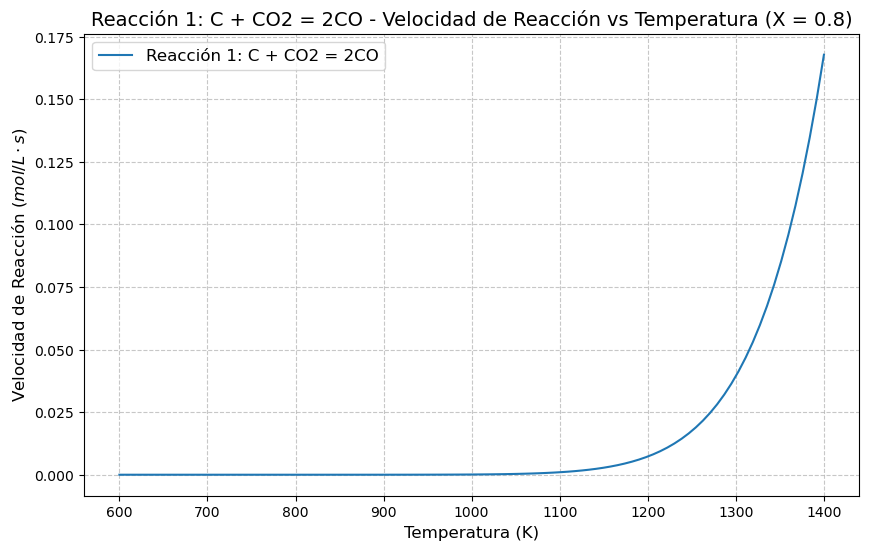

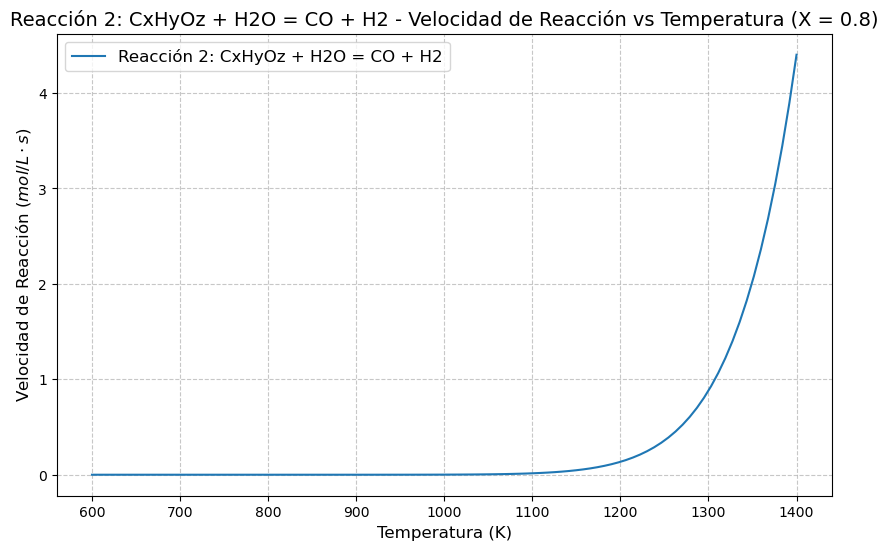

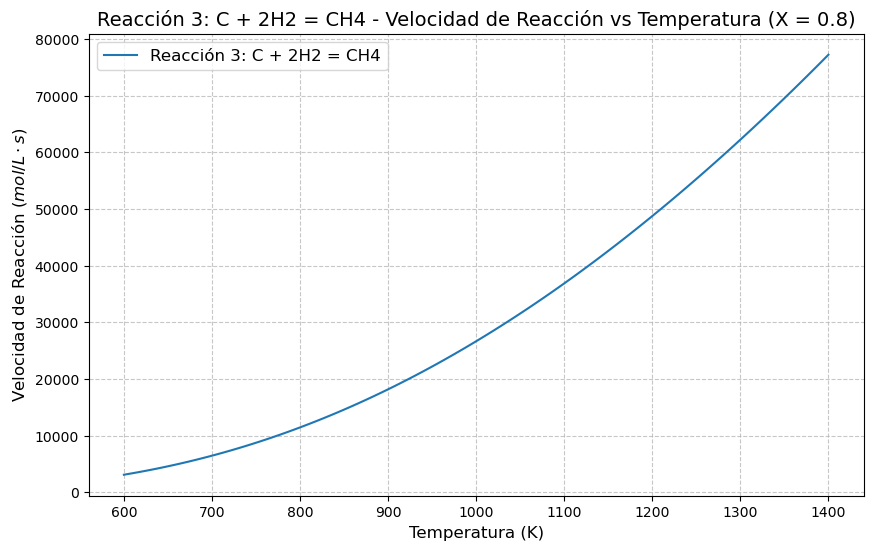

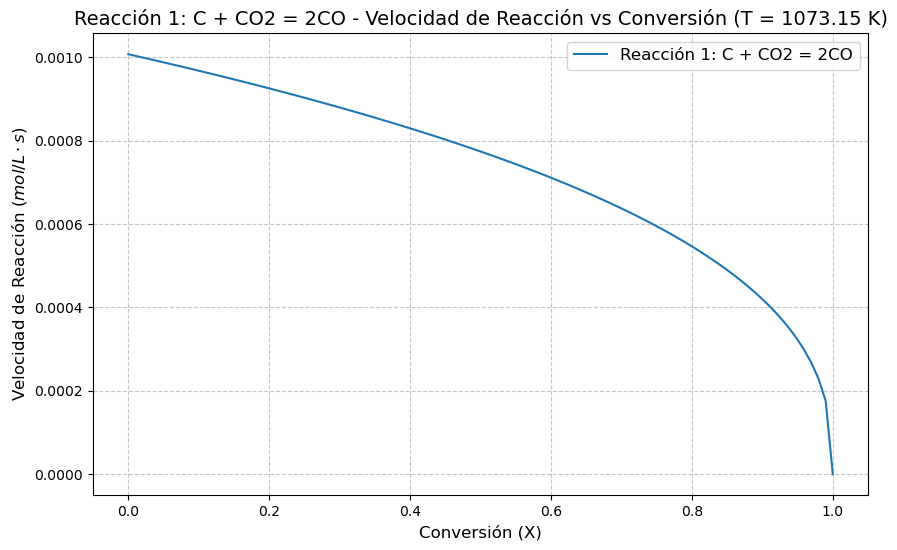

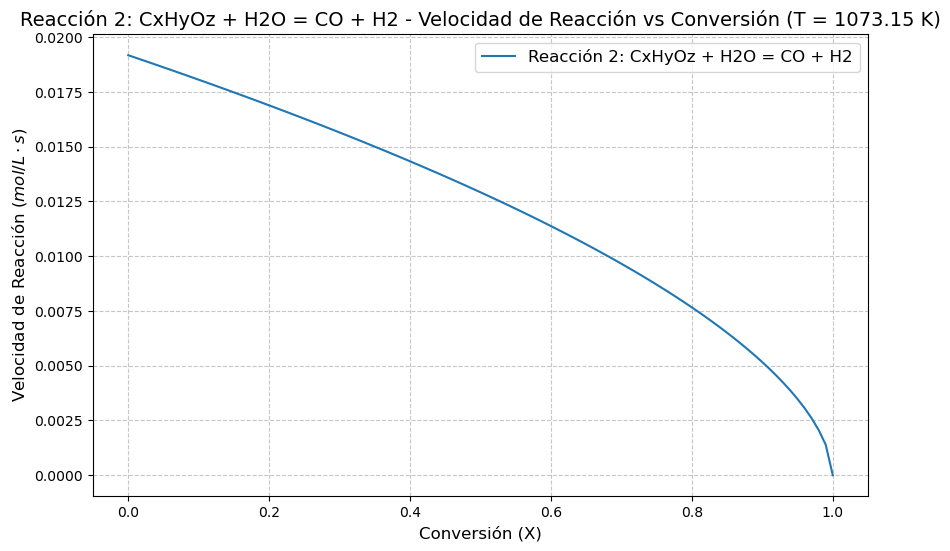

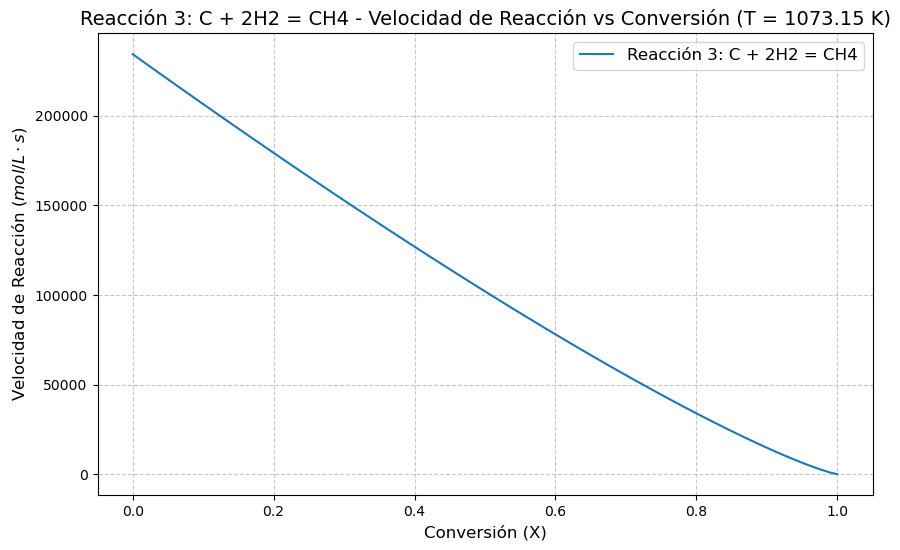

In [214]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes globales
R = 8.314  # Constante de gases ideales (J/mol·K)
P = 1.01325  # Presión en bar
T_range = np.linspace(600, 1400, 100)  # Rango de temperaturas (K)
X = np.linspace(0, 1, 100)  # Conversión de 0 a 1

# Parámetros de reacciones
reactions = {
    "Reacción 1: C + CO2 = 2CO": {
        "A": 3.1e6,  # s^-1 bar^-0.38
        "n": 0.38,
        "Ea": 215e3,  # J/mol
        "P_init": 6.5 / 157.67  # Fracción inicial de CO2
    },
    "Reacción 2: CxHyOz + H2O = CO + H2": {
        "A": 262e6,
        "n": 0.57,
        "Ea": 237e3,
        "P_init": 5.0 / 157.67  # Ejemplo de fracción inicial
    },
    "Reacción 3: C + 2H2 = CH4": {
        "A": 4.189e3,
        "n": 1.2,
        "Ea": 19210,  # J/mol
        "P_init": 3.0 / 157.67
    },
}

# Funciones auxiliares
def reaction_rate(A, Ea, n, P_init, T, X):
    """
    Calcula la velocidad de reacción para una reacción dada.
    """
    P_current = P * (P_init * (1 - X)) * R * T  # Presión parcial en función de la conversión
    k = A * np.exp(-Ea / (R * T))  # Constante de velocidad
    return k * (P_current ** n)

# Graficar velocidad de reacción vs temperatura
for name, params in reactions.items():
    r_t = [reaction_rate(params["A"], params["Ea"], params["n"], params["P_init"], T, 0.8) for T in T_range]
    plt.figure(figsize=(10, 6))
    plt.plot(T_range, r_t, label=name)
    plt.title(f"{name} - Velocidad de Reacción vs Temperatura (X = 0.8)", fontsize=14)
    plt.xlabel("Temperatura (K)", fontsize=12)
    plt.ylabel("Velocidad de Reacción ($mol/L\cdot s$)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.show()

# Graficar velocidad de reacción vs conversión
for name, params in reactions.items():
    r_x = reaction_rate(params["A"], params["Ea"], params["n"], params["P_init"], 1073.15, X)
    plt.figure(figsize=(10, 6))
    plt.plot(X, r_x, label=name)
    plt.title(f"{name} - Velocidad de Reacción vs Conversión (T = 1073.15 K)", fontsize=14)
    plt.xlabel("Conversión (X)", fontsize=12)
    plt.ylabel("Velocidad de Reacción ($mol/L\cdot s$)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.show()


Volumen necesario para CSTR a X = 0.8: 271.72 L
Volumen necesario para PFR a X = 0.8: 148.53 L


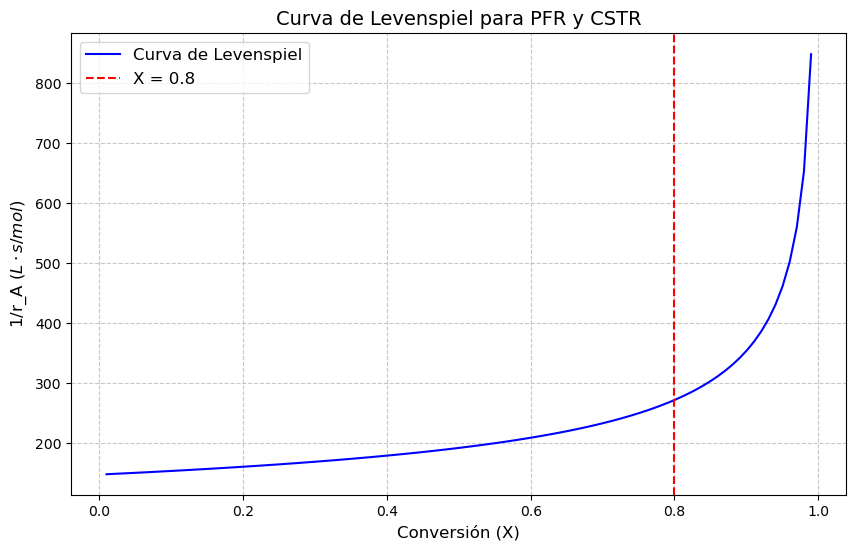

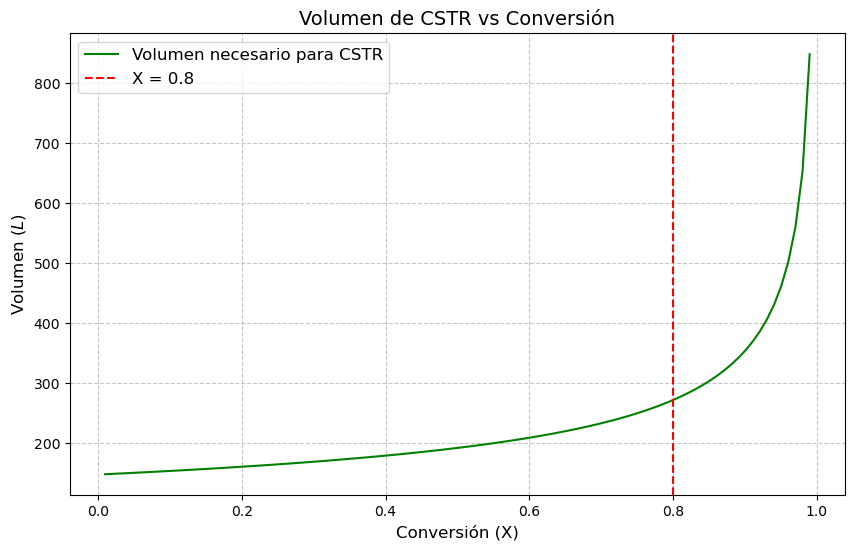

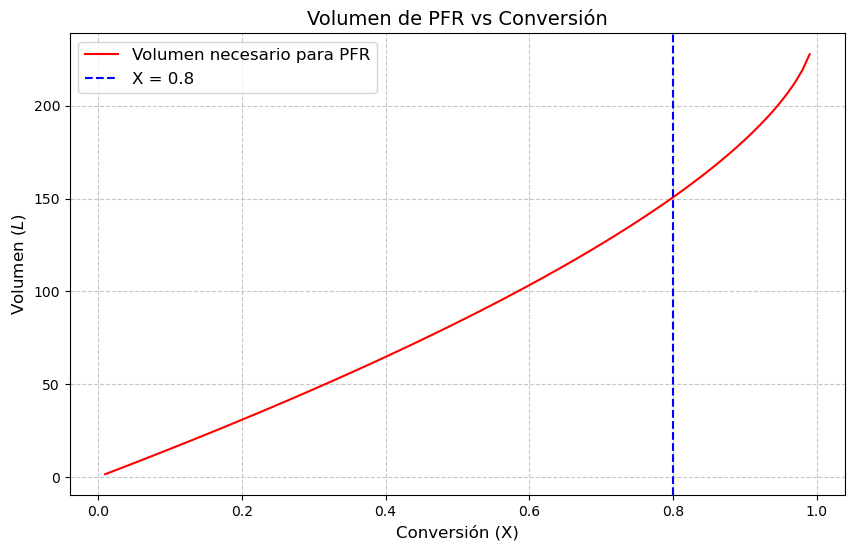

In [215]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes globales
R = 8.314  # Constante de gases ideales (J/mol·K)
T = 1300  # Temperatura en Kelvin
P = 1.0  # Presión en atm
#F_A0 = 157.67 / 3600  # Flujo volumétrico inicial en L/s convertido de L/h
F_A0 = 6.50 / 3600

# Parámetros de la reacción (Reacción genérica)
A = 3.1e6  # Factor pre-exponencial (s^-1 bar^-n)
Ea = 215e3  # Energía de activación (J/mol)
n = 0.38  # Orden de reacción respecto a presión
P_A0 = 0.5  # Presión parcial inicial de A (bar)

# Conversión y velocidad de reacción
X = np.linspace(0.01, 0.99, 100)

# Cálculo de velocidad de reacción
k = A * np.exp(-Ea / (R * T))  # Constante de velocidad a 1300 K
r_A = k * ((P_A0 * (1 - X)) ** n)  # Velocidad de reacción (mol/L·s)

# Ajustar flujo volumétrico inicial para obtener velocidad en función de volumen
F_A0_molar = F_A0 / 22.4  # Convertir flujo volumétrico a molar (mol/s)

# Curva de Levenspiel (1/r_A vs X)
levenspiel_curve = F_A0_molar / r_A

# Cálculo del volumen necesario para CSTR y PFR para X = 0.8
X_target = 0.8
r_A_target = k * ((P_A0 * (1 - X_target)) ** n)  # Velocidad de reacción a X = 0.8
V_CSTR_target = F_A0_molar / r_A_target  # Volumen CSTR para X = 0.8

# Volumen PFR (integral hasta X = 0.8)
index_target = np.where(X >= X_target)[0][0]
V_PFR_target = np.sum(levenspiel_curve[:index_target] * (X[1] - X[0]))

print(f"Volumen necesario para CSTR a X = {X_target}: {V_CSTR_target*1e4:.2f} L")
print(f"Volumen necesario para PFR a X = {X_target}: {V_PFR_target*1e4:.2f} L")

# Gráfica de la curva de Levenspiel
plt.figure(figsize=(10, 6))
plt.plot(X, levenspiel_curve*1e4, label="Curva de Levenspiel", color="blue")
plt.axvline(X_target, color="red", linestyle="--", label=f"X = {X_target}")
plt.title("Curva de Levenspiel para PFR y CSTR", fontsize=14)
plt.xlabel("Conversión (X)", fontsize=12)
plt.ylabel("1/r_A ($L\cdot s / mol$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# Gráfica del volumen de CSTR
plt.figure(figsize=(10, 6))
plt.plot(X, levenspiel_curve*1e4, label="Volumen necesario para CSTR", color="green")
plt.axvline(X_target, color="red", linestyle="--", label=f"X = {X_target}")
plt.title("Volumen de CSTR vs Conversión", fontsize=14)
plt.xlabel("Conversión (X)", fontsize=12)
plt.ylabel("Volumen ($L$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# Gráfica del volumen de PFR
plt.figure(figsize=(10, 6))
plt.plot(X, np.cumsum(levenspiel_curve) * (X[1] - X[0]) *1e4, label="Volumen necesario para PFR", color="red")
plt.axvline(X_target, color="blue", linestyle="--", label=f"X = {X_target}")
plt.title("Volumen de PFR vs Conversión", fontsize=14)
plt.xlabel("Conversión (X)", fontsize=12)
plt.ylabel("Volumen ($L$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.show()


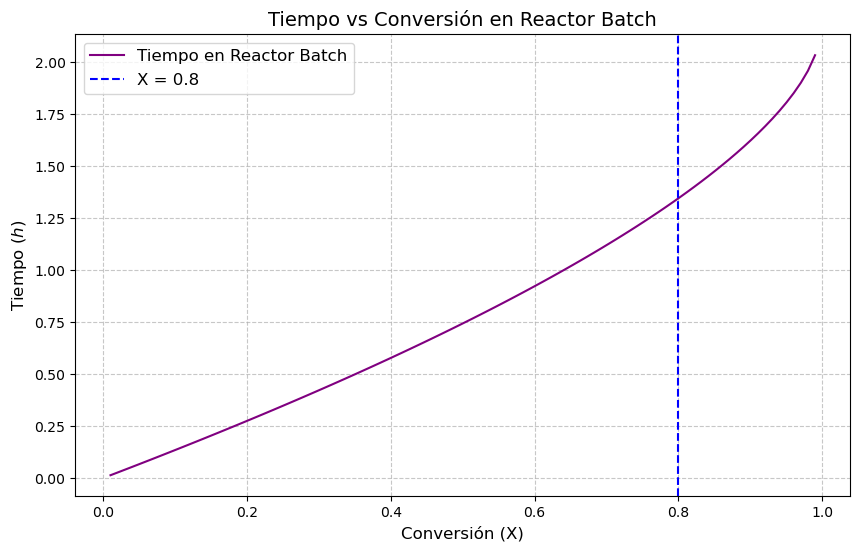

In [216]:
# Cálculo del tiempo necesario en un reactor batch
C_A0 = 2.0  # Concentración inicial (mol/L)
V = 150.0  # Volumen del reactor (L)

def batch_time(C_A0, r_A, X):
    dX = X[1] - X[0]
    integrand = C_A0 / r_A
    return np.cumsum(integrand * dX)  # Tiempo acumulado

time_batch = batch_time(C_A0, r_A, X)  * 3600

# Gráfica del tiempo en reactor batch
plt.figure(figsize=(10, 6))
plt.plot(X, time_batch/1e6, label="Tiempo en Reactor Batch", color="purple")
plt.title("Tiempo vs Conversión en Reactor Batch", fontsize=14)
plt.axvline(X_target, color="blue", linestyle="--", label=f"X = {X_target}")
plt.xlabel("Conversión (X)", fontsize=12)
plt.ylabel("Tiempo ($h$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.show()